In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# ------------------------------
# 1. Generate a Direction-Based 2D Dataset
# ------------------------------
def sample_direction(center_angle, std_angle, n_samples):
    """
    Generate n_samples unit vectors whose angles (in radians)
    are drawn from a Gaussian centered on center_angle (radians)
    with standard deviation std_angle.
    """
    angles = np.random.normal(loc=center_angle, scale=std_angle, size=n_samples)
    # Convert angle to 2d unit vector
    X = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    return X

np.random.seed(42)
n_train = 128 #40
n_test = 128 #16
std_angle = 0.6  # controls angular noise; higher value means more overlap

def create_dataset(n_train, std_angle):

    X_train = []
    y_train = []

    for i in range(4):

        Xi = sample_direction(i*np.pi / 2, std_angle, n_train // 4)
        yi = np.repeat(i, n_train // 4)

        X_train.append(Xi)
        y_train.append(yi)

    return np.concatenate(X_train), np.concatenate(y_train)

In [3]:
X_train, y_train = create_dataset(n_train, std_angle)
X_test, y_test = create_dataset(n_test, std_angle)

[]

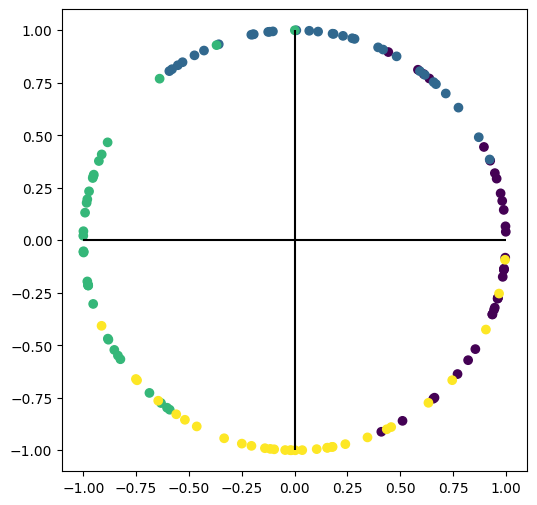

In [4]:
fig, ax = plt.subplots(figsize=(6,6))

plt.hlines(0, xmin=-1, xmax=1, color='black')
plt.vlines(0, ymax=1, ymin=-1, color='black')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1,1.1])


plt.plot()

In [40]:
# ------------------------------
# 3. Train the Original Classifier
# ------------------------------
# We'll use a simple MLP classifier
class Model():

    def __init__(self, X, y) -> None:

        self.clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100),  # two layers with 50 neurons each
                                activation='relu', 
                                solver='adam',
                                alpha=0,         # very low L2 regularization 
                                max_iter=5000,      # more iterations to fit the data exactly
                                random_state=42, early_stopping=False)
        self.clf.fit(X, y)
    
    def score(self, X, y):
        return self.clf.score(X, y)

    def predict(self, X):
        return self.clf.predict(X)
    
class RetrievalAugmentationModel():

    def __init__(self, X, y, memory, alpha=1.0, tau=0.1) -> None:

        self.alpha = alpha
        self.tau = tau

        self.memory = memory

        self.clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100),  # two layers with 50 neurons each
                         activation='relu', 
                         solver='adam',
                         alpha=0,         # very low L2 regularization 
                         max_iter=5000,      # more iterations to fit the data exactly
                         random_state=42, early_stopping=False)
        
        self.clf.fit(np.array([self.retrieval_augment(x) for x in X]), y)

    def retrieval_augment(self, x):
        x_reshaped = x.reshape(1, -1)
        sims = cosine_similarity(x_reshaped, self.memory).flatten()
        
        # Compute softmax weights with temperature tau
        weights = np.exp(sims / self.tau)
        weights /= np.sum(weights)

        # Compute the weighted average (aggregated, or 'denoised', representation)
        hat_x = np.dot(weights, self.memory)
        
        # Blend the original x with the memory-aggregated representation

        blend = (1 - self.alpha) * x + self.alpha * hat_x
        return blend #/ np.linalg.norm(blend)

    def weight(self, x):
        x_reshaped = x.reshape(1, -1)
        sims = cosine_similarity(x_reshaped, self.memory).flatten()
        
        # Compute softmax weights with temperature tau
        weights = np.exp(sims / self.tau)
        weights /= np.sum(weights)

        return weights, sims

    def get_weights(self, X):
        return np.array([self.weight(x) for x in X])

    def score(self, X, y):
        return self.clf.score(np.array([self.retrieval_augment(x) for x in X]), y)

    def predict(self, X):
        return self.clf.predict(np.array([self.retrieval_augment(x) for x in X]))

In [7]:
model = Model(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8984375, 0.71875)

In [8]:
ra_model = RetrievalAugmentationModel(X_train, y_train, memory=X_train, tau=0.01, alpha=1.0)
ra_model.score(X_train, y_train), ra_model.score(X_test, y_test)

(0.890625, 0.734375)

In [15]:
from tqdm import tqdm

all_weights = []
all_sims = []

taus = np.logspace(-1, 0, 5, base=10)

for t in tqdm(taus):
    ra_model = RetrievalAugmentationModel(X_train, y_train, memory=X_train, tau=t, alpha=1.0)
    weights, sims = ra_model.weight(X_test[0])

    all_weights.append(weights)
    all_sims.append(sims)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


In [16]:
import scienceplots

plt.style.use("science")



In [42]:
xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 300),
                     np.linspace(-1.1, 1.1, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predictions for the original classifier
pred_orig = model.predict(grid_points)
pred_orig = pred_orig.reshape(xx.shape)

In [10]:
# Predictions for the original classifier
pred_ra= ra_model.predict(grid_points)
pred_ra = pred_ra.reshape(xx.shape)

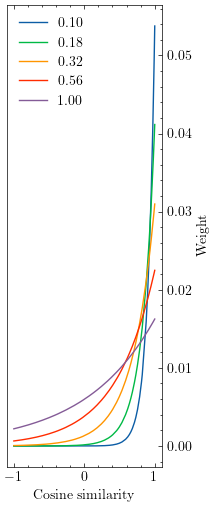

In [13]:
fig, ax = plt.subplots(figsize=(2,6))

for weights, sims in zip(all_weights, all_sims):
    indices = np.argsort(sims)
    ax.plot(sims[indices], weights[indices])
    # ax.scatter(sims, weights)
    # ax.plot(np.arange(1,len(weights)+1), weights)

ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Weight")

# Move y-axis label to the right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.legend([f"{t:.2f}" for t in taus])
plt.show()


In [12]:
test_points = sample_direction(-1.45*np.pi/5, 0, 1)
test_points

array([[ 0.61290705, -0.79015501]])

In [25]:
# 2//3

Alpha: 0 | Train Score: 0.90 | Test Score: 0.72
Alpha: 0.2 | Train Score: 0.86 | Test Score: 0.78
Alpha: 0.4 | Train Score: 0.91 | Test Score: 0.77
Alpha: 0.6 | Train Score: 0.88 | Test Score: 0.74
Alpha: 0.8 | Train Score: 0.88 | Test Score: 0.80
Alpha: 1.0 | Train Score: 0.85 | Test Score: 0.78


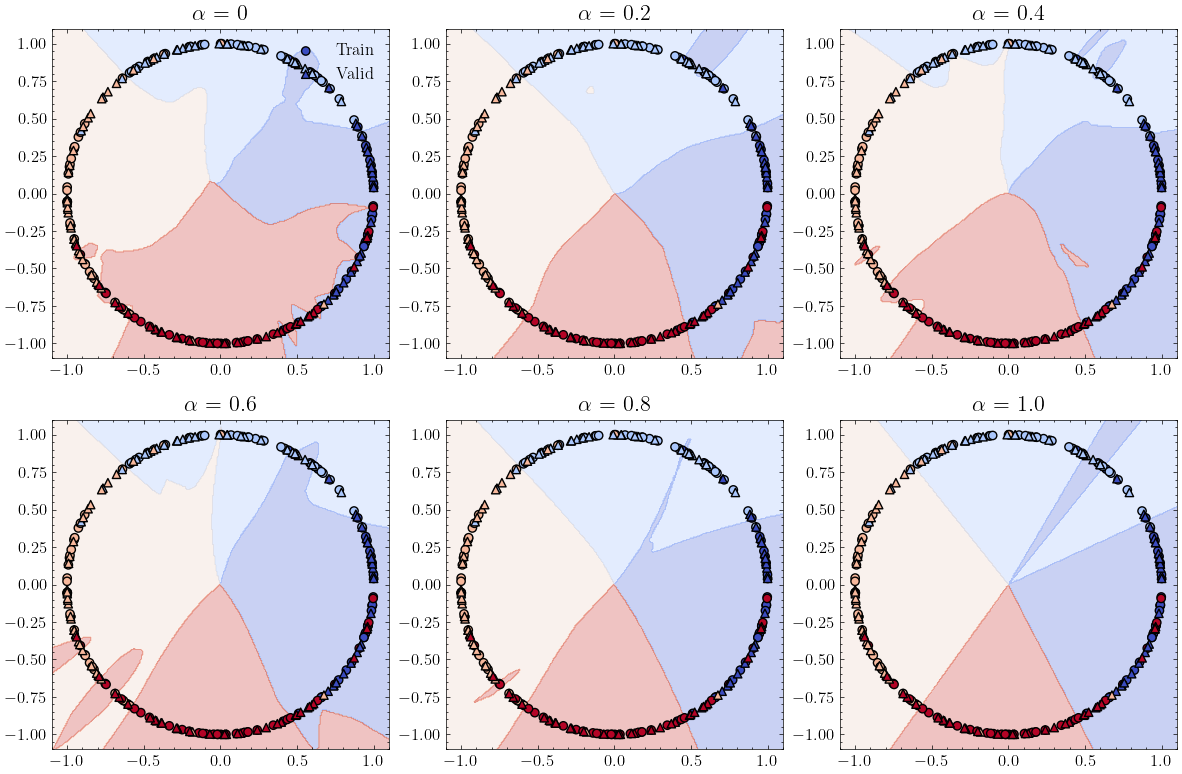

In [47]:
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

plt.figure(figsize=(12, 8))  # Adjusted height for 3 rows

for i, alpha in enumerate(alphas):
    ra_model = RetrievalAugmentationModel(X_train, y_train, memory=X_train, tau=1.0, alpha=alpha) if alpha > 0 else Model(X_train, y_train)
    print(f"Alpha: {alpha} | Train Score: {ra_model.score(X_train, y_train):.2f} | Test Score: {ra_model.score(X_test, y_test):.2f}")

    pred_ra = ra_model.predict(grid_points)
    pred_ra = pred_ra.reshape(xx.shape)

    # 3 rows, 2 columns
    plt.subplot(2, 3, i + 1)
    plt.contourf(xx, yy, pred_ra, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.coolwarm, label="Train")
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', edgecolor='k', cmap=plt.cm.coolwarm, label="Valid")
    # plt.scatter(test_points[:, 0], test_points[:, 1], c='yellow', marker='o', s=100, label="Test sample")

    plt.title(f"$\\alpha$ = {alpha}")
    if i == 0:
        plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("/project/output/db_evo.pdf")
plt.show()


TypeError: Shapes of x (300, 300) and z (50, 50) do not match

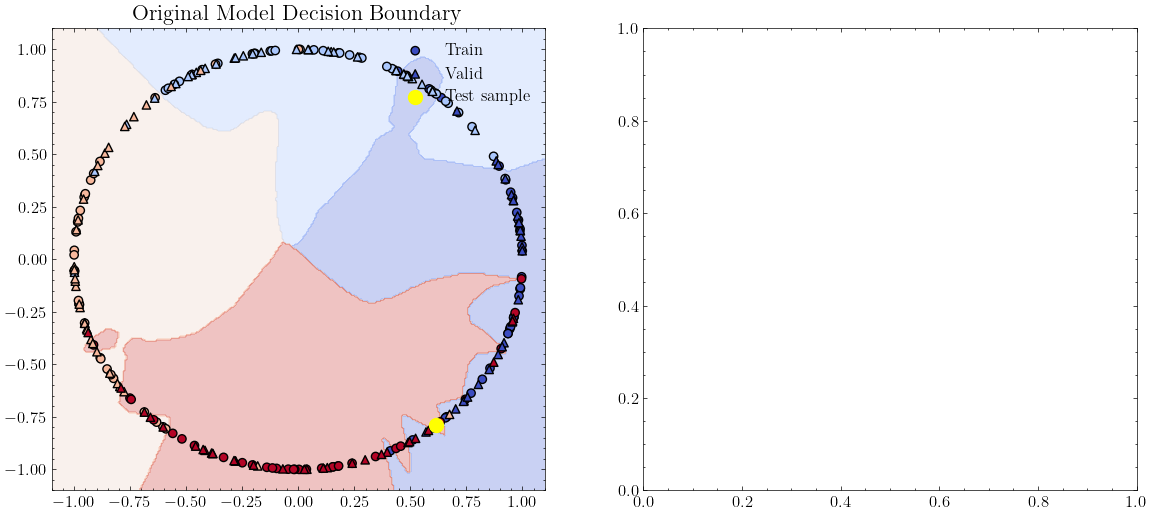

In [43]:
# ------------------------------
# 8. Plot the Decision Boundaries and Points
# ------------------------------
plt.figure(figsize=(14, 6))

# Original Model Decision Boundary
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, pred_orig, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.coolwarm, label="Train")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', edgecolor='k', cmap=plt.cm.coolwarm, label="Valid")

plt.scatter(test_points[:,0], test_points[:,1], c='yellow', marker='o', s=100, label="Test sample")
# plt.scatter(x_adv[0], x_adv[1], c='yellow', marker='X', s=100, label="x_adv (attacked)")

plt.title("Original Model Decision Boundary")
plt.legend(loc="upper right")

# Retrieval-Augmented Model Decision Boundary
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, pred_ra, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.coolwarm, label="Train")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', edgecolor='k', cmap=plt.cm.coolwarm, label="Valid")
# Plot the augmented points corresponding to x0 and x_adv.
# plt.scatter(x0_aug[0], x0_aug[1], c='black', marker='o', s=100, label="x0_aug (clean)")
# plt.scatter(x_adv_aug[0], x_adv_aug[1], c='yellow', marker='X', s=100, label="x_adv_aug (attacked)")
plt.title("Retrieval-Augmented Model Decision Boundary")
plt.legend()

# plt.savefig("/project/output/decision_plot.pdf")
plt.show()

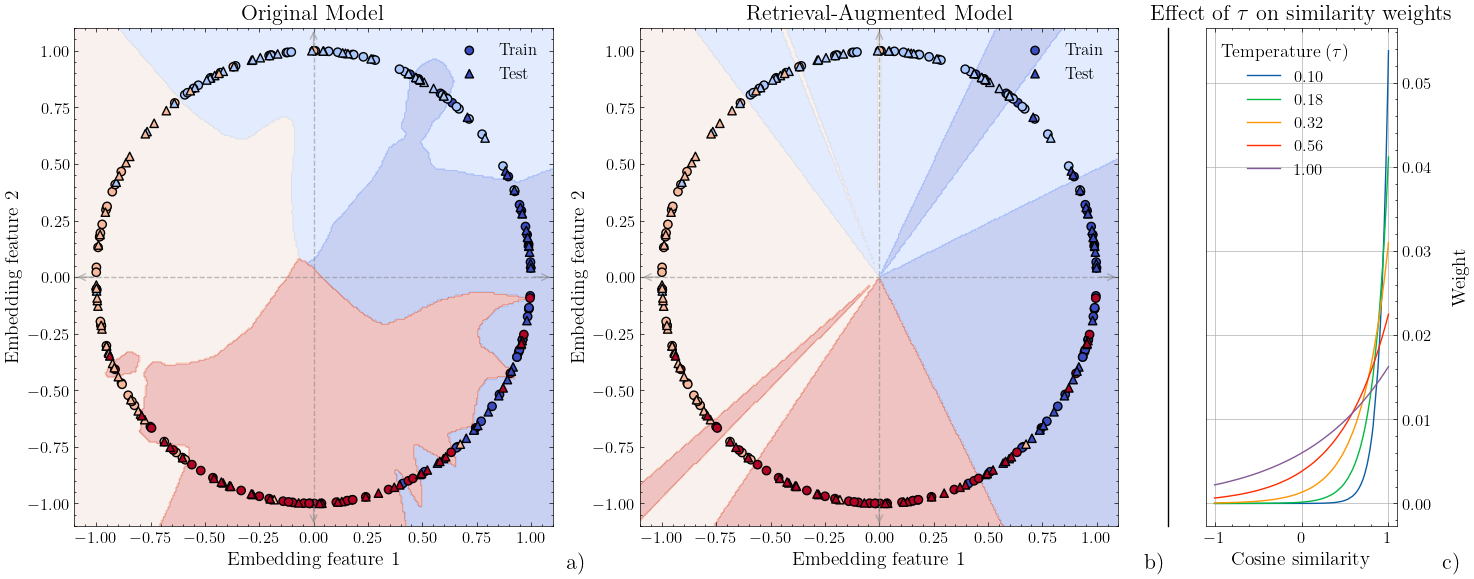

In [17]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# Set global font sizes
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.title_fontsize': 13
})

# Define square bounds
xlim = (xx.min(), xx.max())
ylim = (yy.min(), yy.max())

# Create figure
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.4])

def draw_axes_with_double_arrows(ax, xlim, ylim):
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.annotate('', xy=(xlim[1], 0), xytext=(xlim[1] - 0.1, 0),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
    ax.annotate('', xy=(xlim[0], 0), xytext=(xlim[0] + 0.1, 0),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
    ax.annotate('', xy=(0, ylim[1]), xytext=(0, ylim[1] - 0.1),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
    ax.annotate('', xy=(0, ylim[0]), xytext=(0, ylim[0] + 0.1),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

# Original Model
ax0 = fig.add_subplot(gs[0, 0])
ax0.contourf(xx, yy, pred_orig, alpha=0.3, cmap=plt.cm.coolwarm)
ax0.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.coolwarm, label="Train")
ax0.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', edgecolor='k', cmap=plt.cm.coolwarm, label="Test")
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_title("Original Model")
ax0.set_xlabel("Embedding feature 1")
ax0.set_ylabel("Embedding feature 2")
ax0.tick_params(labelsize=12)
ax0.legend()
draw_axes_with_double_arrows(ax0, xlim, ylim)

# Retrieval-Augmented Model
ax1 = fig.add_subplot(gs[0, 1])
ax1.contourf(xx, yy, pred_ra, alpha=0.3, cmap=plt.cm.coolwarm)
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.coolwarm, label="Train")
ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', edgecolor='k', cmap=plt.cm.coolwarm, label="Test")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_title("Retrieval-Augmented Model")
ax1.set_xlabel("Embedding feature 1")
ax1.set_ylabel("Embedding feature 2")
ax1.tick_params(labelsize=12)
ax1.legend()
draw_axes_with_double_arrows(ax1, xlim, ylim)

# Cosine Similarity vs. Weight
ax2 = fig.add_subplot(gs[0, 2])
for weights, sims in zip(all_weights, all_sims):
    indices = np.argsort(sims)
    ax2.plot(sims[indices], weights[indices])
ax2.set_xlabel("Cosine similarity")
ax2.set_ylabel("Weight", labelpad=15)
ax2.set_title("Effect of $\\tau$ on similarity weights")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(labelsize=12)
ax2.grid()
ax2.legend([f"{t:.2f}" for t in taus], title="Temperature ($\\tau$)", loc='upper left')

# Add vertical separator between left two and right plot
separator = Line2D([1.89/2.4, 1.89/2.4], [0.1, 0.93], transform=fig.transFigure,
                   color='black', linewidth=1)
fig.add_artist(separator)

# Add group labels
fig.text(1.9/2.4 - 0.02, 0.03, "b)", fontsize=16, fontweight='bold')
fig.text(1.9/2.4/2 - 0.01, 0.03, "a)", fontsize=16, fontweight='bold')
fig.text(1 - 0.03, 0.03, "c)", fontsize=16, fontweight='bold')

# Save then show (saving first preserves layout and artist positioning)
plt.tight_layout()
plt.savefig("/project/output/toyexamples.pdf", bbox_inches='tight')
plt.show()